In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical

# specifically for cnn
from tensorflow.keras.layers import Dropout, Flatten,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [ ]:
#Tensorboard Things

%load_ext tensorboard
import tensorflow as tf
import datetime, os


In [ ]:
#Importing Image Dataset

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fid = drive.ListFile({'q':"title='smearbinary.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('smearbinary.zip')

In [ ]:
!unzip smearbinary.zip

Archive:  smearbinary.zip
   creating: smearbinary/
   creating: smearbinary/herlev/
   creating: smearbinary/herlev/Abnormal/
  inflating: smearbinary/herlev/Abnormal/148494967-148494986-001.BMP  
  inflating: smearbinary/herlev/Abnormal/148495491-148495504-001.BMP  
  inflating: smearbinary/herlev/Abnormal/148495553-148495585-001.BMP  
  inflating: smearbinary/herlev/Abnormal/148495842-148495854-001.BMP  
  inflating: smearbinary/herlev/Abnormal/148495842-148495863-001.BMP  
  inflating: smearbinary/herlev/Abnormal/148495885-148495896-001.BMP  
  inflating: smearbinary/herlev/Abnormal/148497551-148497588-001.BMP  
  inflating: smearbinary/herlev/Abnormal/148497551-148497625-001.BMP  
  inflating: smearbinary/herlev/Abnormal/148497676-148497704-001.BMP  
  inflating: smearbinary/herlev/Abnormal/148497676-148497718-001.BMP  
  inflating: smearbinary/herlev/Abnormal/148497788-148497816-001.BMP  
  inflating: smearbinary/herlev/Abnormal/148497788-148497816-002.BMP  
  inflating: smearbin

In [ ]:
#For the distribution of the dataset
import os
import numpy as np
import glob
import shutil
class DatasetDivision:
	def __init__(self, root_dir="",output_dir=""):
		self.root_dir = root_dir
		self.output_dir = output_dir
		print("Instance of the class created")
	def printnow(self, new_dir):
		print("Just testing that the method calling is working"+new_dir)
	def divide_dataset(self, root_dir,output_dir):
		self.root_dir =root_dir
		self.output_dir = output_dir
		if os.path.exists(self.output_dir):
			if not os.path.exists(os.path.join(self.output_dir,'train')):
				os.mkdir(os.path.join(self.output_dir,'train')) 
				os.mkdir(os.path.join(self.output_dir,'val')) 
				os.mkdir(os.path.join(self.output_dir,'test')) 
		else:
			os.mkdir(self.output_dir)
			os.mkdir(os.path.join(self.output_dir,'train')) 
			os.mkdir(os.path.join(self.output_dir, 'val')) 
			os.mkdir(os.path.join(self.output_dir, 'test'))
		# Split train/val/test sets
		for file in os.listdir(root_dir):            
			classes_path = os.path.join(root_dir, file)  
			class_files = [name for name in glob.glob(os.path.join(classes_path,'*.bmp'))] 
			train_and_valid, test = train_test_split(class_files, test_size=0.20, random_state=42)
			train, val = train_test_split(train_and_valid, test_size=0.25, random_state=42)

			#creating the training, validation and testing directories where the data will be moved.
			train_dir = os.path.join(self.output_dir, 'train',file) #creates the train data path for Divided_Dataset 
			val_dir = os.path.join(self.output_dir, 'val', file) #creates the validation data path for Divided_Dataset 
			test_dir = os.path.join(self.output_dir, 'test',file) #creates the test data path for Divided_Dataset 
			if not os.path.exists(train_dir):
				os.mkdir(train_dir)
			if not os.path.exists(val_dir):
				os.mkdir(val_dir)
			if not os.path.exists(test_dir):
				os.mkdir(test_dir)

			for frame_folders in train:
				#get only the last directory of the path frame_folders
				frame_folder = os.path.join(root_dir,file,frame_folders)
				shutil.move(frame_folder,train_dir)
			for frame_folders in val:
				frame_folder = os.path.join(root_dir,file,frame_folders)
				shutil.move(frame_folder,val_dir)
			for frame_folders in test:
				frame_folder = os.path.join(root_dir,file,frame_folders)
				shutil.move(frame_folder,test_dir)
			print('Dataset Division finished.')

In [ ]:
path_dir= "/content/smearbinary/herlev/"
output_dir = "/content/herle2005Format/"
datasetdiv1 = DatasetDivision(path_dir,output_dir)
datasetdiv1.printnow("The new guy")
datasetdiv1.divide_dataset(path_dir, output_dir)

Instance of the class created
Just testing that the method calling is workingThe new guy
Dataset Division finished.
Dataset Division finished.


['Abnormal', 'Normal']


(2, 2)

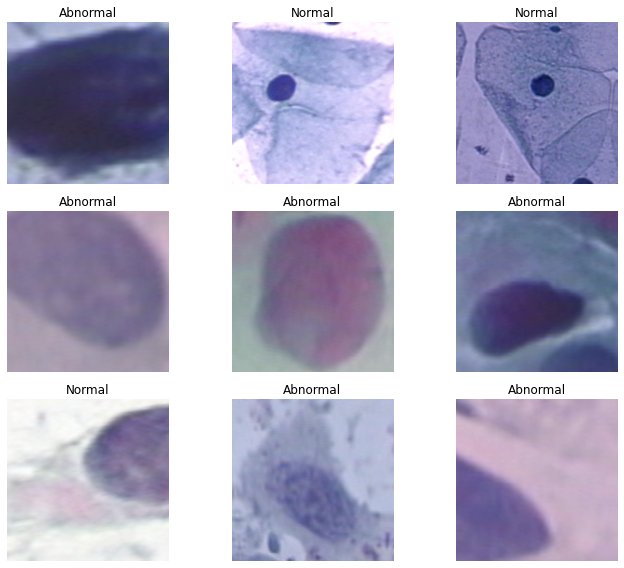

In [ ]:
from fastai.vision import *
batch_size = 10
path_img = output_dir
## Loading data 
data = ImageDataBunch.from_folder(path=path_img, train='train',
            valid='val', ds_tfms=get_transforms(), size = 224, bs=batch_size)#, check_ext=False)
## Normalizing data based on Image net parameters
data.normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(10,8))
print(data.classes)
len(data.classes),data.c

In [ ]:

!pip install python 3.3

ERROR: Could not find a version that satisfies the requirement python (from versions: none)
ERROR: No matching distribution found for python


In [ ]:
pip install git+https://github.com/aleju/imgaug.git

  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-eynnbx4y
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-eynnbx4y
  Created wheel for imgaug: filename=imgaug-0.4.0-cp36-none-any.whl size=971107 sha256=55ae2eb0154a212d6b2dd3e4e4310701eb4fef1782e05939bf636de3b6456e0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-j_pzbwxm/wheels/65/3d/94/ee32cbeaa29c473a4db74c2d21904ac747311fdca4732665f0
Successfully built imgaug
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
#Creating a class for data augmentation
import  cv2
import imgaug
import imageio
import os
import numpy as np
from imgaug import augmenters as iaa


class DataAugmentation:


	def __init__(self, root_dir="",output_dir=""):
		self.root_dir = root_dir
		self.output_dir = output_dir
		print("Instance of the DataAugmentation class created")


	def augmentation_of_image(self, test_image, output_path):
		self.test_image = test_image;
		self.output_path = output_path;
		#define the Augmenters



		#properties: A range of values signifies that one of these numbers is randmoly chosen for every augmentation for every batch

		# Apply affine transformations to each image.
		rotate = iaa.Affine(rotate=(-90,90));  
		scale = iaa.Affine(scale={"x": (0.5, 0.9), "y": (0.5,0.9)}); 
		translation = iaa.Affine(translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)});
		shear = iaa.Affine(shear=(-2, 2)); 
		zoom = iaa.PerspectiveTransform(scale=(0.01, 0.15), keep_size=True) 
		h_flip = iaa.Fliplr(1.0); 
		v_flip = iaa.Flipud(1.0); 
		padding=iaa.KeepSizeByResize(iaa.CropAndPad(percent=(0.05, 0.25)))


		#More augmentations
		blur = iaa.GaussianBlur(sigma=(0, 1.22)) 
		contrast = iaa.contrast.LinearContrast((0.75, 1.5)); 
		contrast_channels = iaa.LinearContrast((0.75, 1.5), per_channel=True) 
		sharpen = iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5));
		gauss_noise = iaa.AdditiveGaussianNoise(scale=0.111*255, per_channel=True) 
		laplace_noise = iaa.AdditiveLaplaceNoise(scale=(0, 0.111*255)) 


		#Brightness 
		brightness = iaa.Multiply((0.35,1.65)) 
		brightness_channels = iaa.Multiply((0.5, 1.5), per_channel=0.75) 

		#CHANNELS (RGB)=(Red,Green,Blue)
		red =iaa.WithChannels(0, iaa.Add((10, 100))) 
		red_rot = iaa.WithChannels(0,iaa.Affine(rotate=(0, 45))) 
		green= iaa.WithChannels(1, iaa.Add((10, 100)))
		green_rot=iaa.WithChannels(1,iaa.Affine(rotate=(0, 45))) 
		blue=iaa.WithChannels(2, iaa.Add((10, 100)))
		blue_rot=iaa.WithChannels(2,iaa.Affine(rotate=(0, 45))) 

		#colors
		channel_shuffle =iaa.ChannelShuffle(1.0); #shuffle all images of the batch
		grayscale = iaa.Grayscale(1.0)
		hue_n_saturation = iaa.MultiplyHueAndSaturation((0.5, 1.5), per_channel=True) #change hue and saturation with this range of values for different values 
		add_hue_saturation = iaa.AddToHueAndSaturation((-50, 50), per_channel=True) #add more hue and saturation to its pixels
		#Quantize colors using k-Means clustering
		kmeans_color = iaa.KMeansColorQuantization(n_colors=(4, 16)) #quantizes to k means 4 to 16 colors (randomly chosen). Quantizes colors up to 16 colors

		#Alpha Blending 
		blend =iaa.AlphaElementwise((0, 1.0), iaa.Grayscale((0,1.0))) ; #blend depending on which value is greater

		#Contrast augmentors
		clahe = iaa.CLAHE(tile_grid_size_px=((3, 21),[0,2,3,4,5,6,7])) #create a clahe contrast augmentor H=(3,21) and W=(0,7)
		histogram = iaa.HistogramEqualization() #performs histogram equalization

		#Augmentation list of metadata augmentors
		OneofRed = iaa.OneOf( [red]);
		OneofGreen = iaa.OneOf( [green] );
		OneofBlue = iaa.OneOf( [blue]);
		contrast_n_shit = iaa.OneOf([contrast, brightness, brightness_channels]);
		SomeAug = iaa.SomeOf(2,[rotate,scale, translation, shear, h_flip,v_flip],random_order=True);
		SomeClahe = iaa.SomeOf(2, [clahe, iaa.CLAHE(clip_limit=(1, 10)),iaa.CLAHE(tile_grid_size_px=(3, 21)),iaa.GammaContrast((0.5, 2.0)), iaa.AllChannelsCLAHE() , iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)],random_order=True) #Random selection from clahe augmentors
		edgedetection= iaa.OneOf([iaa.EdgeDetect(alpha=(0, 0.7)),iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0))]);# Search in some images either for all edges or for directed edges.These edges are then marked in a black and white image and overlayed with the original image using an alpha of 0 to 0.7.
		canny_filter = iaa.OneOf([iaa.Canny(), iaa.Canny(alpha=(0.5, 1.0), sobel_kernel_size=[3, 7])]); #choose one of the 2 canny filter options
		OneofNoise = iaa.OneOf([blur, gauss_noise, laplace_noise])
		Color_1 = iaa.OneOf([channel_shuffle,grayscale, hue_n_saturation , add_hue_saturation, kmeans_color]);
		Color_2 = iaa.OneOf([channel_shuffle,grayscale, hue_n_saturation , add_hue_saturation, kmeans_color]);
		Flip = iaa.OneOf([histogram , v_flip, h_flip]);

		#Define the augmentors used in the Data Augmentation
		Augmentors= [SomeAug, SomeClahe, SomeClahe, edgedetection,sharpen, canny_filter, OneofRed, OneofGreen, OneofBlue, OneofNoise, Color_1, Color_2, Flip, contrast_n_shit]


		for i in range(0,14):
			img = cv2.imread(test_image) 
			images = np.array([img for _ in range(14)], dtype=np.uint8) 
			images_aug = Augmentors[i].augment_images(images)  
			cv2.imwrite(os.path.join(output_path,test_image +"new"+str(i)+'.jpg'), images_aug[i]) 

In [ ]:
import imgaug; print(imgaug.__file__)

/usr/local/lib/python3.6/dist-packages/imgaug/__init__.py


In [ ]:
import shutil

class DataAugmentation_Extension:
	def __init__(self, directory=""):
		self.directory = directory
		print("Instance of DataAugmentation_Extension class created")

	def printnow(self, dir):
		print("Just testing that the method calling is working "+ dir)


	def extend_dataset(self,directory):
		#Create an instance of class 
		print("HEY")
		library_augment= DataAugmentation();
		self.directory = directory 
		if not os.path.exists(self.directory):
			print("ERROR! Couldn't find directory!")
		else:
			print("Directory exists")
		for file in os.listdir(directory):            #for any file inside the root directory 
			classes_path = os.path.join(directory, file)  #So for every folder class we create a class directory
			class_files = [name for name in glob.glob(os.path.join(classes_path,'*.BMP'))]  #alternatively we can use the globe as mentioned
			print(class_files); #call augmentation for all class_files
			for i in range(len(class_files)):
				library_augment.augmentation_of_image(class_files[i], classes_path)

In [ ]:
print(dir(iaa))

['ABCMeta', 'Add', 'AddElementwise', 'AddToBrightness', 'AddToHue', 'AddToHueAndSaturation', 'AddToSaturation', 'AdditiveGaussianNoise', 'AdditiveLaplaceNoise', 'AdditivePoissonNoise', 'Affine', 'AffineCv2', 'AllChannelsCLAHE', 'AllChannelsHistogramEqualization', 'Alpha', 'AlphaElementwise', 'AssertLambda', 'AssertShape', 'Augmenter', 'AverageBlur', 'AveragePooling', 'Batch', 'BilateralBlur', 'BlendAlpha', 'BlendAlphaBoundingBoxes', 'BlendAlphaCheckerboard', 'BlendAlphaElementwise', 'BlendAlphaFrequencyNoise', 'BlendAlphaHorizontalLinearGradient', 'BlendAlphaMask', 'BlendAlphaRegularGrid', 'BlendAlphaSegMapClassIds', 'BlendAlphaSimplexNoise', 'BlendAlphaSomeColors', 'BlendAlphaVerticalLinearGradient', 'BoundingBoxesMaskGen', 'CLAHE', 'CSPACE_ALL', 'CSPACE_BGR', 'CSPACE_CIE', 'CSPACE_GRAY', 'CSPACE_HLS', 'CSPACE_HSV', 'CSPACE_Lab', 'CSPACE_Luv', 'CSPACE_RGB', 'CSPACE_YCrCb', 'CSPACE_YUV', 'Canny', 'Cartoon', 'CenterCropToAspectRatio', 'CenterCropToFixedSize', 'CenterCropToMultiplesOf', 

In [ ]:
print(imgaug.__version__)

0.4.0


In [ ]:
import imgaug
print(imgaug.__file__)

/usr/local/lib/python3.6/dist-packages/imgaug/__init__.py


In [ ]:
print(imgaug.__version__)

0.4.0


In [ ]:
#data augmentation
#directories
target_directory = "/content/herle2005Format/train"
#create an instance of the class
datasetda = DataAugmentation_Extension()
datasetda.extend_dataset(target_directory)

Instance of DataAugmentation_Extension class created
HEY
Instance of the DataAugmentation class created
Directory exists
['/content/herle2005Format/train/Normal/153958154-153958248-002.BMP', '/content/herle2005Format/train/Normal/157223321-157223341-001.BMP', '/content/herle2005Format/train/Normal/209565409-209565600-001.BMP', '/content/herle2005Format/train/Normal/153956444-153956458-003.BMP', '/content/herle2005Format/train/Normal/157267263-157267286-002.BMP', '/content/herle2005Format/train/Normal/157185781-157185793-001.BMP', '/content/herle2005Format/train/Normal/153956279-153956296-001.BMP', '/content/herle2005Format/train/Normal/157185208-157185238-001.BMP', '/content/herle2005Format/train/Normal/157222534-157222607-001.BMP', '/content/herle2005Format/train/Normal/157223779-157224126-001.BMP', '/content/herle2005Format/train/Normal/157267059-157267072-001.BMP', '/content/herle2005Format/train/Normal/157224458-157224483-001.BMP', '/content/herle2005Format/train/Normal/157223394-1

In [ ]:
import numpy as np
from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout
from keras.applications import Xception
from keras.models import Model, Sequential

base_model = Xception(weights='imagenet', include_top=False)
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

83689472/83683744 [==============================] - 2s 0us/step
0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_ac

In [ ]:
### MODELS
import numpy as np
from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout
from keras.applications import Xception
from keras.models import Model, Sequential


"""
Create a new feature extractor based on the pretrained VGG16 model:
The model is frozen from the bottom layer up to 36. 
block5_sepconv1 is then pooled with GlobalMaxPool2D, and
connected to a Dense layer with 1024 neurons, and then to the softmax layer.
"""
def xcep(seed = None):
    np.random.seed(seed)
    vgg16 = Xception(weights="imagenet", include_top=False)
    for layer in vgg16.layers[:36]:
        layer.trainable = False
    for layer in vgg16.layers[36:]:
        layer.trainable = True
    y = (vgg16.get_layer("block5_sepconv1")).output
    mx_y = GlobalMaxPool2D()(y)
    x = BatchNormalization()(mx_y)
    x = Dropout(.5)(x)
    x = Dense(1024, activation='relu', name="dense_1024")(x)
    x = BatchNormalization()(x)
    x = Dropout(.5)(x)
    preds = Dense(2,activation='softmax')(x)
    model = Model(inputs=vgg16.input, outputs=preds)
    return model

In [ ]:
import numpy as np
from keras.layers import Dense, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



"""LOAD DATA"""
# path to folder with data
path = "/content/herle2005Format/"
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   rotation_range = 5, fill_mode="nearest",
                                   zoom_range=[1/1.0, 1/1.0], width_shift_range=0.0, height_shift_range=0.0, 
                                   horizontal_flip = True, vertical_flip=True,
                                   brightness_range=[0.5, 1.3], channel_shift_range=20)

no_DA_IDG = ImageDataGenerator()

# in training set: use data augmentation image data generator, for validation and test: no data augmentation.
training_set = train_datagen.flow_from_directory(path+"train/",
                                                target_size=(224, 224), # typical imagenet dimensions
                                                color_mode='rgb',
                                                batch_size=32,
                                                class_mode='categorical', shuffle=True)



validation_set =  no_DA_IDG.flow_from_directory(path+"val/",
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                shuffle=True)



test_set_V2 = no_DA_IDG.flow_from_directory(path+"test/",
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=False)

###############################################################################################
"""CREATE & TRAIN MODELS"""

model_xcep = xcep()

""" The model was trained with a Adam with a learning rate of 1e-3 for 50 epochs.
Then the training was continued for 50 epochs at a lower learning
rate.
The weights loaded at the end of the block result from a good run (based on validation score) following the described
training regime.
"""


epochs = 50
opt = Adam(learning_rate=1e-3)
model_xcep.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
model_xcep.fit_generator(generator=training_set, epochs=epochs, validation_data=validation_set, verbose=2)

opt = Adam(learning_rate=1e-4)
model_xcep.fit_generator(generator=training_set, epochs=epochs, validation_data=validation_set, verbose=2)

# save model weights
model_xcep.save_weights("K_xcep_T2_herlev_binary.h5")

"""EVALUATE PERFORMANCE ON THE TEST SET"""

y_test = test_set_V2.classes
pred = np.argmax(model_xcep.predict_generator(test_set_V2, steps = test_set_V2.n), axis=1)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


Found 8235 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
83689472/83683744 [==============================] - 2s 0us/step
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
258/258 - 131s - loss: 0.7290 - acc: 0.7360 - val_loss: 0.6690 - val_acc: 0.8315
Epoch 2/50
258/258 - 130s - loss: 0.5323 - acc: 0.7974 - val_loss: 0.4803 - val_acc: 0.8424
Epoch 3/50
258/258 - 130s - loss: 0.4452 - acc: 0.8225 - val_loss: 0.4920 - val_acc: 0.8696
Epoch 4/50
258/258 - 129s - loss: 0.4231 - acc: 0.8335 - val_loss: 0.4894 - val_acc: 0.8533
Epoch 5/50
258/258 - 125s - loss: 0.4012 - acc: 0.8453 - val_loss: 0.5430 - val_acc: 0.8261
Epoch 6/50
258/258 - 128s - loss: 0.3888 - acc: 0.8458 - val_loss: 0.4434 - val_acc: 0.8641
Epoch 7/50
258/258 - 129s - loss: 0.3682 - acc: 0.8565 - val_loss: 0.4435 - val_acc: 0.8696
Epoch 8/50
258/258 - 129s - loss: 0.3536 - acc: 0.8572 - val_loss: 0.4418 - val_acc: 0.8696

In [ ]:
model_xcep.save("model_xcep_herlev_binary.h5")

In [ ]:
from google.colab import files
files.download("/content/model_xcep_herlev_binary.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>